In [1]:
import sys  
#sys.executable} -m pip install pandas
import pandas as pd
import numpy as np

#!{sys.executable} -m pip install geopandas
import geopandas as gpd

import requests

import warnings
warnings.filterwarnings('ignore')

#!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

#!{sys.executable} -m pip install folium
import folium
#!{sys.executable} -m pip install geopy

import geopy.distance
import glob
from sklearn.metrics import silhouette_samples, silhouette_score


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# loading all the county files
file_list = glob.glob('processed_data/selected_*_final.csv')
file_list

['processed_data/selected_nj_bg_data_final.csv',
 'processed_data/selected_LA_bg_data_final.csv',
 'processed_data/selected_HUSTON_bg_data_final.csv',
 'processed_data/selected_ny_bg_data_final.csv']

In [3]:
# selecting only few for testing
f_list_2 = ['processed_data/selected_nj_bg_data_final.csv',
 'processed_data/selected_ny_bg_data_final.csv']

In [4]:
df_list = []
for file in file_list:
    tp_df=pd.read_csv(file)
    df_list.append(tp_df)

In [5]:
# appending loaded dataframes
df=pd.concat(df_list)

In [6]:
df.COUNTY.unique()

array(['Bergen County', 'Essex County', 'Hudson County',
       'Middlesex County', 'Morris County', 'Union County',
       'Los Angeles County', 'Harris County', 'Bronx County',
       'Kings County', 'New York County', 'Queens County',
       'Richmond County'], dtype=object)

In [7]:
df.shape

(1835, 53)

### Merging Race Data

In [8]:
# adding the race information
df_race=pd.read_csv('processed_data/selected_states_race_data.csv')

In [9]:
df_race.shape

(98220, 4)

In [10]:
df=df.merge(df_race,on='GISJOIN',how='left')

In [11]:
df.shape

(1835, 56)

In [12]:
cords=df[['lat','lon']].values.tolist()

In [13]:
df.STATE.unique()

array(['New Jersey', 'California', 'Texas', 'New York'], dtype=object)

In [14]:
m = folium.Map(location=cords[0],zoom_control=3)

for point in cords:
    folium.Circle(
        radius=10,
        location=point,
        popup=str(point),#"The Waterfront",
        color="crimson",
        fill=False,).add_to(m)


m

### Analysing per County

In [15]:
res_analysis_cols =['Total_Population', 'Total_Working','Worked from home','Chinese Restaurant_count', 'Indian Restaurant_count', 'Italian Restaurant_count','Mexican Restaurant_count']


In [16]:
df.rename(columns={'income_group_<$10k':'income_group_<10k',
       'income_group_$10k_to_$25k':'income_group_10k_to_25k',
    'income_group_$25k_to_$50k':  'income_group_25k_to_50k',
       'income_group_$50k_to_$100k':'income_group_50k_to_100k',
    'income_group_$100k_to_$200k':'income_group_100k_to_200k',
                         'income_group_>$200k':'income_group_>200k'
},inplace=True)

In [17]:
income_groups= ['income_group_<10k',
       'income_group_10k_to_25k', 'income_group_25k_to_50k',
       'income_group_50k_to_100k', 'income_group_100k_to_200k',
       'income_group_>200k']

In [18]:
df['Indo-Chinese Restaurants Count'] = df['Chinese Restaurant_count'] + df['Indian Restaurant_count']

In [19]:
debug_cols =  ['GISJOIN', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA', 'TRACTA','BLCK_GRPA','INTPTLAT','INTPTLON', 'geometry', 'lat', 'lon']

time_for_travel_cols = ['travel_time_<30mins', 'travel_time_30_to_60_mins','travel_time_>60_mins']
income_group_cols = ['income_group_<10k', 'income_group_10k_to_25k','income_group_25k_to_50k', 'income_group_50k_to_100k','income_group_100k_to_200k', 'income_group_>200k']
total_population_col = ['Total_Population', 'White alone', 'Asian alone']
mode_of_commute_col = ['Total_Working', 'Car, truck, or van', 'Taxicab', 'Motorcycle',
       'Bicycle', 'Walked', 'Other means of transport', 'Worked from home']
work_force_cols =[
       'In labor force', 'In labor force: Civilian labor force',
       'In labor force: Civilian labor force: Employed',
       'In labor force: Civilian labor force: Unemployed',
       'In labor force: Armed Forces', 'Not in labor force']

restaurent_cols = [ 'Chinese Restaurant_count',
       'Indian Restaurant_count', 'Italian Restaurant_count',
       'Mexican Restaurant_count', 'Chinese Restaurant_avg_distance',
       'Indian Restaurant_avg_distance', 'Italian Restaurant_avg_distance',
       'Mexican Restaurant_avg_distance']
transport_fs_cols =[ 'Bus Stop_count',
       'Metro Station_count', 'Public Transportation_count',
       'Rail Station_count', 'Bus Stop_avg_distance',
       'Metro Station_avg_distance', 'Public Transportation_avg_distance',
       'Rail Station_avg_distance']
business_park_cols =['Business_Parks_Count']
selected_cols = total_population_col + time_for_travel_cols+income_group_cols+mode_of_commute_col+work_force_cols+transport_fs_cols

selected_cols = total_population_col +income_group_cols#+ income_group_cols+mode_of_commute_col+work_force_cols+transport_fs_cols

target=['Indo-Chinese Restaurants Count']


model_cols =selected_cols+target



In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS


In [21]:
df_model_1 = df.copy()#df[df.STATE.isin(['New York','New Jersey'])].copy()#[df.COUNTY=='Kings County'].copy()

In [22]:
df_model_1.isna().sum()

GISJOIN                                                0
STATE                                                  0
STATEA                                                 0
COUNTY                                                 0
COUNTYA                                                0
TRACTA                                                 0
BLCK_GRPA                                              0
travel_time_<30mins                                    0
travel_time_30_to_60_mins                              0
travel_time_>60_mins                                   0
income_group_<10k                                      0
income_group_10k_to_25k                                0
income_group_25k_to_50k                                0
income_group_50k_to_100k                               0
income_group_100k_to_200k                              0
income_group_>200k                                     0
Total_Population                                       0
Total_Working                  

In [23]:
df_model_1 = df_model_1.fillna(0)

In [24]:
df_model_1=df_model_1[df_model_1['Asian alone']!=0]

In [25]:
df_model_1['restaurant_per_person']=df_model_1['Indo-Chinese Restaurants Count']/df_model_1['Total_Population']
df_model_1['restaurant_per_asian']=df_model_1['Indo-Chinese Restaurants Count']/df_model_1['Asian alone']
df_model_1['identifier']=df_model_1['COUNTY']+'_T'+df_model_1['TRACTA'].apply(str)+'_BG'+df_model_1['BLCK_GRPA'].apply(str)


In [26]:
df_model_1.shape

(1500, 60)

In [27]:
df_model_1.shape

(1500, 60)

In [35]:
# selecting prediction data
current_indices = np.random.choice(df_model_1.shape[0], 100, replace=False)
train_indices=[i for i in range(df_model_1.shape[0]) if i not in current_indices]

In [36]:
df_current = df_model_1.iloc[current_indices]

In [37]:
df_model = df_model_1.iloc[train_indices]

In [38]:
X = df_model.values

In [39]:
aug_indices = np.random.randint(X.shape[0], size=10000)

In [40]:
X_aug = X[aug_indices]

In [41]:
X_aug.shape

(10000, 60)

In [42]:
df_aug=pd.DataFrame(X_aug,columns=df_model.columns)

In [43]:
df_aug.shape

(10000, 60)

In [44]:
#scaler = StandardScaler()
#X = scaler.fit_transform(df_model[model_cols])

### Scoring the Block Groups

In [45]:
score_df = df_aug[['identifier','restaurant_per_person','restaurant_per_asian','Total_Working','income_group_100k_to_200k']]


In [46]:
score_df.restaurant_per_asian.isna().sum()

0

In [47]:
score_df[score_df.restaurant_per_asian.isna()]

,identifier,restaurant_per_person,restaurant_per_asian,Total_Working,income_group_100k_to_200k


In [48]:
score_df.shape

(10000, 5)

In [49]:
scale_cols=score_df.columns[1:]
score_df

,identifier,restaurant_per_person,restaurant_per_asian,Total_Working,income_group_100k_to_200k
0,Essex County_T21801_BG1,0.0,0.0,1228,468
1,Los Angeles County_T103202_BG1,0.0,0.0,896,256
2,Los Angeles County_T502700_BG2,0.0,0.0,718,208
3,Los Angeles County_T503401_BG2,0.003281,0.135593,916,208
4,Bergen County_T26100_BG1,0.0,0.0,403,124
...,...,...,...,...,...
9995,Bronx County_T4001_BG1,0.033684,0.186047,556,87
9996,Los Angeles County_T403403_BG1,0.0,0.0,878,317
9997,Los Angeles County_T135205_BG2,0.0,0.0,271,108
9998,Los Angeles County_T131024_BG2,0.0,0.0,1142,122


In [50]:
score_normal=score_df.copy()

In [51]:
def scaleColumn(data):
    '''
    normalizing the columns for scoring
    '''
    row_list = data.values.tolist()
    row_min,row_max = min(row_list),max(row_list)
    op=[]
    for i,val in enumerate(row_list):
        op.append((val-row_min)/(row_max-row_min))
    return op

def getScore(data,weights):
    '''
    scoring the rows with weights
    '''
    score = 0
    for key,value in weights.items():
        score = score + data[key]*value
    return score

In [52]:
# normalizing the columns
for col in scale_cols:
    print(col)
    score_df[col]=scaleColumn(score_df[col])

restaurant_per_person
restaurant_per_asian
Total_Working
income_group_100k_to_200k


In [53]:
# reversing the numbers as we need restaurent locations with lower PerPerson restaurant
score_df['restaurant_per_person']=1-score_df['restaurant_per_person']
score_df['restaurant_per_asian']=1-score_df['restaurant_per_asian']

In [54]:

w_dict= {'restaurant_per_asian': 50,
 'restaurant_per_person': 20,
 'Total_Working': 10,
 'income_group_100k_to_200k': 20}
w_dict


{'restaurant_per_asian': 50,
 'restaurant_per_person': 20,
 'Total_Working': 10,
 'income_group_100k_to_200k': 20}

In [55]:
score_df['score']=score_df.apply(getScore,weights=w_dict,axis=1)

In [56]:
score_normal['score']=score_df['score']

In [57]:
score_df.head()

,identifier,restaurant_per_person,restaurant_per_asian,Total_Working,income_group_100k_to_200k,score
0,Essex County_T21801_BG1,1.000000,1.000000,0.232048,0.243370,77.187878
1,Los Angeles County_T103202_BG1,1.000000,1.000000,0.169312,0.133125,74.355628
2,Los Angeles County_T502700_BG2,1.000000,1.000000,0.135676,0.108164,73.520051
3,Los Angeles County_T503401_BG2,0.973884,0.977772,0.173091,0.108164,72.260458
4,Bergen County_T26100_BG1,1.000000,1.000000,0.076153,0.064483,72.051178


In [58]:
score_normal

,identifier,restaurant_per_person,restaurant_per_asian,Total_Working,income_group_100k_to_200k,score
0,Essex County_T21801_BG1,0.0,0.0,1228,468,77.187878
1,Los Angeles County_T103202_BG1,0.0,0.0,896,256,74.355628
2,Los Angeles County_T502700_BG2,0.0,0.0,718,208,73.520051
3,Los Angeles County_T503401_BG2,0.003281,0.135593,916,208,72.260458
4,Bergen County_T26100_BG1,0.0,0.0,403,124,72.051178
...,...,...,...,...,...,...
9995,Bronx County_T4001_BG1,0.033684,0.186047,556,87,65.068719
9996,Los Angeles County_T403403_BG1,0.0,0.0,878,317,74.956040
9997,Los Angeles County_T135205_BG2,0.0,0.0,271,108,71.635339
9998,Los Angeles County_T131024_BG2,0.0,0.0,1142,122,73.426825


In [59]:
df_iter_1 = df_model.merge(score_normal[['identifier','score']],on='identifier')

In [60]:
df_iter_1.shape

(10000, 61)

In [61]:
debug_cols =  ['GISJOIN', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA', 'TRACTA','BLCK_GRPA','INTPTLAT','INTPTLON', 'geometry', 'lat', 'lon']

time_for_travel_cols = ['travel_time_<30mins', 'travel_time_30_to_60_mins','travel_time_>60_mins']
income_group_cols = ['income_group_<10k', 'income_group_10k_to_25k','income_group_25k_to_50k', 'income_group_50k_to_100k','income_group_100k_to_200k', 'income_group_>200k']
total_population_col = ['Total_Population', 'White alone', 'Asian alone']
mode_of_commute_col = ['Total_Working', 'Car, truck, or van', 'Taxicab', 'Motorcycle',
       'Bicycle', 'Walked', 'Other means of transport', 'Worked from home']
work_force_cols =[
       'In labor force', 'In labor force: Civilian labor force',
       'In labor force: Civilian labor force: Employed',
       'In labor force: Civilian labor force: Unemployed',
       'In labor force: Armed Forces', 'Not in labor force']

restaurent_cols = [ 'Chinese Restaurant_count',
       'Indian Restaurant_count', 'Italian Restaurant_count',
       'Mexican Restaurant_count', 'Chinese Restaurant_avg_distance',
       'Indian Restaurant_avg_distance', 'Italian Restaurant_avg_distance',
       'Mexican Restaurant_avg_distance']
transport_fs_cols =[ 'Bus Stop_count',
       'Metro Station_count', 'Public Transportation_count',
       'Rail Station_count', 'Bus Stop_avg_distance',
       'Metro Station_avg_distance', 'Public Transportation_avg_distance',
       'Rail Station_avg_distance']
business_park_cols =['Business_Parks_Count']
selected_cols = total_population_col + time_for_travel_cols+income_group_cols+mode_of_commute_col+work_force_cols+transport_fs_cols

selected_cols = total_population_col +income_group_cols#+ income_group_cols+mode_of_commute_col+work_force_cols+transport_fs_cols


model_cols = business_park_cols + work_force_cols + transport_fs_cols +time_for_travel_cols

target=['score']


In [62]:
df_iter_1[model_cols].head()

,Business_Parks_Count,In labor force,In labor force: Civilian labor force,In labor force: Civilian labor force: Employed,In labor force: Civilian labor force: Unemployed,In labor force: Armed Forces,Not in labor force,Bus Stop_count,Metro Station_count,Public Transportation_count,Rail Station_count,Bus Stop_avg_distance,Metro Station_avg_distance,Public Transportation_avg_distance,Rail Station_avg_distance,travel_time_<30mins,travel_time_30_to_60_mins,travel_time_>60_mins
0,2.0,315,315,308,7,0,298,0.0,0.0,1.0,0.0,0.0,0.0,1511.0,0.0,119,127,58
1,2.0,315,315,308,7,0,298,0.0,0.0,1.0,0.0,0.0,0.0,1511.0,0.0,119,127,58
2,2.0,315,315,308,7,0,298,0.0,0.0,1.0,0.0,0.0,0.0,1511.0,0.0,119,127,58
3,2.0,315,315,308,7,0,298,0.0,0.0,1.0,0.0,0.0,0.0,1511.0,0.0,119,127,58
4,2.0,315,315,308,7,0,298,0.0,0.0,1.0,0.0,0.0,0.0,1511.0,0.0,119,127,58


In [63]:
df_iter_1[target].head()

,score
0,71.354483
1,71.354483
2,71.354483
3,71.354483
4,71.354483


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

In [67]:
X=df_iter_1[model_cols].values
y=df_iter_1[target].values

In [68]:

sss = ShuffleSplit(n_splits=1, test_size=0.3)

X = df_iter_1[model_cols].values
y = df_iter_1[target].values

sss.get_n_splits(X, y)
train_index, test_index = next(sss.split(X, y)) 

X_train, X_test = X[train_index], X[test_index] 
y_train, y_test = y[train_index], y[test_index]

In [69]:
X_train.shape,X_test.shape

((7000, 18), (3000, 18))

In [70]:
df_train=df_iter_1.iloc[train_index]
df_test=df_iter_1.iloc[test_index]

In [71]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [72]:
y_pred=model.predict(X_test)

In [73]:
y_pred.shape

(3000,)

In [74]:
err=np.abs((y_pred.reshape(-1,1)-y_test)*100/y_test)

In [75]:
err.reshape(1,-1)

array([[1.37870859e-13, 1.21786412e-02, 2.26073449e-13, ...,
        1.37098599e-13, 2.57432628e-02, 1.97648244e-13]])

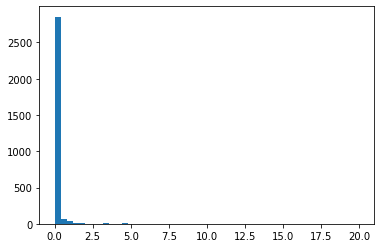

In [76]:
plt.hist(err,bins=50,range=(0,20))
plt.show()

In [77]:
model.feature_importances_

array([0.06690762, 0.06881208, 0.04140973, 0.16269621, 0.02634842,
       0.00046399, 0.03001826, 0.02835792, 0.086569  , 0.01602894,
       0.0141162 , 0.0434859 , 0.29632196, 0.01413425, 0.00729139,
       0.02404209, 0.04183079, 0.03116525])

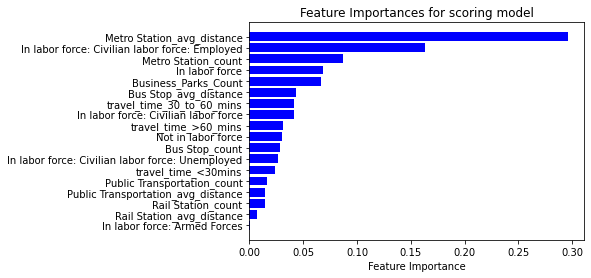

In [78]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances for scoring model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [model_cols[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

In [79]:
np.mean(err)

0.10375183372914089

In [81]:
X_current=df_current[model_cols]

In [82]:
y_pred_current=model.predict(X_current)

In [83]:
X_current.shape

(100, 18)

In [84]:
y_pred_current.shape

(100,)

In [85]:
df_current['score']=y_pred_current

In [86]:
df_current[debug_cols[:-5]+['score']].sort_values(by='score',ascending=False)

,GISJOIN,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLCK_GRPA,score
1417,G48020104553001,Texas,48,Harris County,201,455300,1,93.444244
142,G34001700054003,New Jersey,34,Hudson County,17,5400,3,79.550531
1069,G06003709201212,California,6,Los Angeles County,37,920121,2,76.837441
1382,G48020104321012,Texas,48,Harris County,201,432101,2,76.727736
675,G06003704013041,California,6,Los Angeles County,37,401304,1,76.713138
...,...,...,...,...,...,...,...,...
1752,G36008100551001,New York,36,Queens County,81,55100,1,59.649712
1727,G36008100174001,New York,36,Queens County,81,17400,1,58.647318
1600,G36000500059021,New York,36,Bronx County,5,5902,1,58.146907
1761,G36008100711004,New York,36,Queens County,81,71100,4,57.082084


In [88]:
df_current[df_current.GISJOIN=='G48020104553001'].T

,1417
GISJOIN,G48020104553001
STATE,Texas
STATEA,48
COUNTY,Harris County
COUNTYA,201
...,...
Indo-Chinese Restaurants Count,6.0
restaurant_per_person,0.000756
restaurant_per_asian,0.003254
identifier,Harris County_T455300_BG1


In [104]:
gdf = gpd.GeoDataFrame(df_current, 
            geometry=gpd.points_from_xy(df_current.lon, df_current.lat))
gdf.head()

,GISJOIN,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLCK_GRPA,travel_time_<30mins,travel_time_30_to_60_mins,travel_time_>60_mins,...,Rail Station_avg_distance,Business_Parks_Count,Total_Population_Race,White alone,Asian alone,Indo-Chinese Restaurants Count,restaurant_per_person,restaurant_per_asian,identifier,score
242,G34002300081014,New Jersey,34,Middlesex County,23,8101,4,259,325,96,...,0.0,3.0,1221,1122,91,0.0,0.000000,0.000000,Middlesex County_T8101_BG4,73.483946
329,G34002700440002,New Jersey,34,Morris County,27,44000,2,194,59,177,...,1816.0,6.0,1026,617,409,2.0,0.001949,0.004890,Morris County_T44000_BG2,70.903495
530,G06003701831011,California,6,Los Angeles County,37,183101,1,69,71,11,...,1270.0,20.0,650,301,31,8.0,0.012308,0.258065,Los Angeles County_T183101_BG1,70.166123
616,G06003702753113,California,6,Los Angeles County,37,275311,3,237,349,24,...,0.0,113.0,1516,479,422,9.0,0.005937,0.021327,Los Angeles County_T275311_BG3,70.667429
309,G34002700420001,New Jersey,34,Morris County,27,42000,1,321,283,41,...,512.0,9.0,951,761,132,0.0,0.000000,0.000000,Morris County_T42000_BG1,71.150245


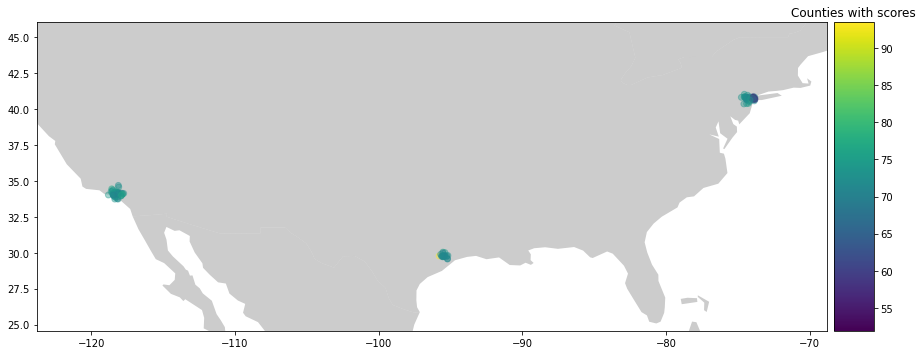

In [133]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(15,10))
world[world.continent=='North America'].plot(ax=ax, alpha=0.4, color='grey')
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(column='score', ax=ax, legend=True,cax=cax,alpha=0.4)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5, maxx+5)
ax.set_ylim(miny-5, maxy+5)
plt.title('Counties with scores')
plt.show()

In [157]:
from folium import plugins

map = folium.Map(location=[35, -100], tiles="cartodbpositron", zoom_start = 4.48,min_zoom=4,max_zoom=9)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry ]

heat_data
plugins.HeatMap(heat_data).add_to(map)

map